C:\Users\datog\AppData\Local\Temp\ipykernel_29996\1029249418.py:43: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(TICKER, start=START)["Adj Close"].dropna()
[*********************100%***********************]  1 of 1 completed


[INFO] market load failed: 'Adj Close'; using synthetic GBM
[INFO] source: synthetic; n=2000
rets n=1999, rv n=1979

Hurst estimates (point):
  Returns:  R/S=0.573  DFA=0.518
  RealVol:  R/S=0.788  DFA=0.988


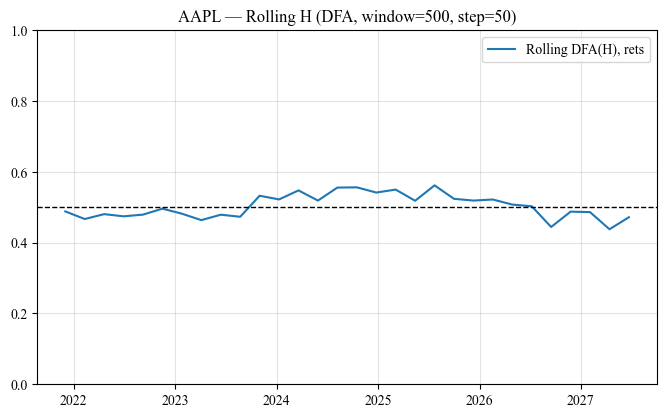

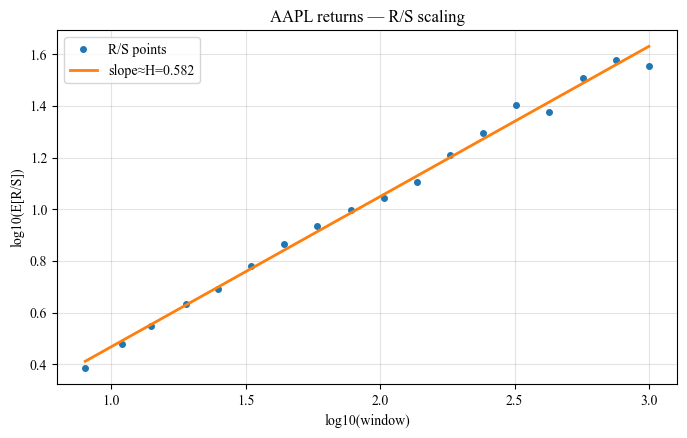

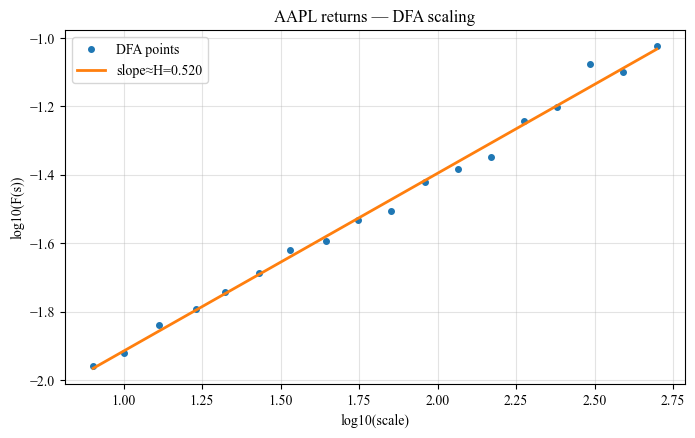


Summary:
returns  R/S   H=0.573
returns  DFA   H=0.518
realvol  R/S   H=0.788
realvol  DFA   H=0.988


In [4]:

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
import src.hurst as hurst
from src.hurst import hurst_dfa, hurst_rs
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os

import src.hurst as hurst
from src.hurst import hurst_dfa, hurst_rs
plt.rcParams.update({
    "figure.figsize": (8.0, 4.6),
    "axes.grid": True,
    "grid.alpha": 0.35
})
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)



plt.rcParams.update({"figure.figsize": (8, 4.6), "axes.grid": True, "grid.alpha": 0.35})

# -------------------------
# 1) Load prices (market → fallback synthetic)
# -------------------------
TICKER = "AAPL"
START  = "2020-01-01"

USE_MARKET = True
try:
    if USE_MARKET:
        import yfinance as yf
        px = yf.download(TICKER, start=START)["Adj Close"].dropna()
        source = "market"
    else:
        raise RuntimeError("forced synthetic")
except Exception as e:
    print(f"[INFO] market load failed: {e}; using synthetic GBM")
    rng = np.random.RandomState(42)
    n = 2000
    mu, sig = 0.05, 0.25
    dt = 1/252
    lnS = np.cumsum((mu-0.5*sig**2)*dt + sig*np.sqrt(dt)*rng.randn(n))
    px = pd.Series(np.exp(lnS), index=pd.date_range("2020-01-01", periods=n, freq="B"))
    source = "synthetic"

print(f"[INFO] source: {source}; n={len(px)}")

# -------------------------
# 2) Build series: log-returns and a realized-vol proxy
# -------------------------
rets = np.log(px).diff().dropna()
rv   = rets.rolling(21).std().dropna()   # 1M realized-vol proxy (daily)
print(f"rets n={len(rets)}, rv n={len(rv)}")

# -------------------------
# 3) Hurst estimates (point estimates)
# -------------------------
H_rs_rets  = hurst_rs(rets.values, min_window=8)
H_dfa_rets = hurst_dfa(rets.values, order=1)

H_rs_rv  = hurst_rs(rv.values, min_window=8) if len(rv) > 100 else np.nan
H_dfa_rv = hurst_dfa(rv.values, order=1)     if len(rv) > 100 else np.nan

print("\nHurst estimates (point):")
print(f"  Returns:  R/S={H_rs_rets:.3f}  DFA={H_dfa_rets:.3f}")
print(f"  RealVol:  R/S={H_rs_rv:.3f}  DFA={H_dfa_rv:.3f}")

# -------------------------
# 4) Rolling H (quick & optional)
# -------------------------
def rolling_hurst(x, win=500, step=50, method="dfa"):
    x = np.asarray(x, float)
    idx, vals = [], []
    for i in range(win, len(x)+1, step):
        seg = x[i-win:i]
        h = hurst_dfa(seg, order=1) if method == "dfa" else hurst_rs(seg)
        idx.append(i)
        vals.append(h)
    return np.array(idx), np.array(vals)

idx_dfa, roll_dfa = rolling_hurst(rets.values, win=500, step=50, method="dfa")
if len(roll_dfa):
    t = rets.index[idx_dfa-1]
    plt.plot(t, roll_dfa, label="Rolling DFA(H), rets")
    plt.axhline(0.5, color="k", lw=1, ls="--")
    plt.title(f"{TICKER} — Rolling H (DFA, window=500, step=50)")
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.show()

# -------------------------
# 5) Diagnostics: show the log–log regressions used by estimators
#    (re-implement the scaling curves just for plotting)
# -------------------------

def rs_curve(y, min_w=8, max_w=None, npts=18):
    x = np.asarray(y, float); x = x[~np.isnan(x)]
    n = len(x); 
    if max_w is None: max_w = n//2
    ws = np.unique(np.round(np.logspace(np.log10(min_w), np.log10(max_w), npts)).astype(int))
    out = []
    for w in ws:
        nb = n//w
        if nb < 2: continue
        vals = []
        for i in range(nb):
            seg = x[i*w:(i+1)*w] - x[i*w:(i+1)*w].mean()
            if seg.size < 2: continue
            Z = np.cumsum(seg)
            R = Z.max() - Z.min()
            S = seg.std(ddof=1)
            if S > 0: vals.append(R/S)
        if vals:
            out.append((w, np.mean(vals)))
    if not out: return None, None
    W, RS = np.array([u for u,_ in out]), np.array([v for _,v in out])
    return np.log10(W), np.log10(RS)

def dfa_curve(y, order=1, npts=18):
    x = np.asarray(y, float); x = x[~np.isnan(x)]
    n = len(x); 
    Y = np.cumsum(x - x.mean())
    smin, smax = 8, max(n//4, 9)
    ss = np.unique(np.round(np.logspace(np.log10(smin), np.log10(smax), npts)).astype(int))
    out = []
    for s in ss:
        nw = n//s
        if nw < 2: continue
        Yc = Y[:nw*s].reshape(nw, s)
        t = np.arange(s, dtype=float)
        f2s = []
        for j in range(nw):
            z = Yc[j]
            if np.allclose(z, z[0]): 
                f2s.append(0.0); continue
            co = np.polyfit(t, z, order)
            tr = np.polyval(co, t)
            f2s.append(np.mean((z-tr)**2))
        if f2s:
            out.append((s, np.sqrt(np.mean(f2s))))
    if not out: return None, None
    S, F = np.array([u for u,_ in out]), np.array([v for _,v in out])
    return np.log10(S), np.log10(F)

# Plot scaling for returns: R/S
lw, lr = rs_curve(rets.values, min_w=8)
if lw is not None:
    Hhat, b = np.polyfit(lw, lr, 1)
    plt.plot(lw, lr, "o", ms=4, label="R/S points")
    plt.plot(lw, Hhat*lw + b, "-", lw=2, label=f"slope≈H={Hhat:.3f}")
    plt.xlabel("log10(window)")
    plt.ylabel("log10(E[R/S])")
    plt.title(f"{TICKER} returns — R/S scaling")
    plt.legend(); plt.show()

# Plot scaling for returns: DFA
ls, lf = dfa_curve(rets.values, order=1)
if ls is not None:
    Hhat, b = np.polyfit(ls, lf, 1)
    plt.plot(ls, lf, "o", ms=4, label="DFA points")
    plt.plot(ls, Hhat*ls + b, "-", lw=2, label=f"slope≈H={Hhat:.3f}")
    plt.xlabel("log10(scale)")
    plt.ylabel("log10(F(s))")
    plt.title(f"{TICKER} returns — DFA scaling")
    plt.legend(); plt.show()

# -------------------------
# 6) Summary table
# -------------------------
rows = [
    ("returns", "R/S",  H_rs_rets),
    ("returns", "DFA",  H_dfa_rets),
    ("realvol", "R/S",  H_rs_rv),
    ("realvol", "DFA",  H_dfa_rv),
]
print("\nSummary:")
for a, b, v in rows:
    print(f"{a:8s} {b:4s}  H={v:.3f}")



    
